# Quantum_Magnetometer eval_nnRL

In [ ]:
# ==== Bootstrap (eval-only) + Params + Imports ====
from pathlib import Path
from pathlib import Path as _P
import sys, importlib.util, importlib, os, re, math, shutil
from datetime import datetime
import typing as tp
from typing import List, Optional, Tuple, Literal, Any


EVAL_ROOT = Path("/mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL").resolve()

# 1) Ensure EVAL_ROOT is FIRST on sys.path; remove other MagNav roots if present
def _rm_from_syspath(prefix: str):
    for p in list(sys.path):
        if prefix in p:
            sys.path.remove(p)

# Clean up the previously added training/BNN paths (to prevent them from being imported first)
_rm_from_syspath("/mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-training/Train-RL-Federal")
_rm_from_syspath("/mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-training/queso-main")

if str(EVAL_ROOT) in sys.path:
    sys.path.remove(str(EVAL_ROOT))
sys.path.insert(0, str(EVAL_ROOT))

print("[sys.path[0]] ->", sys.path[0], "  has src?:", (EVAL_ROOT/"src").exists())

# --- add examples/ to sys.path so nv_center_dc.py is importable ---
EXAMPLES_DIR = EVAL_ROOT / "examples"
if str(EXAMPLES_DIR) not in sys.path:
    sys.path.insert(0, str(EXAMPLES_DIR))
print("[examples dir]", EXAMPLES_DIR, " exists?:", EXAMPLES_DIR.exists())

# 2) Purge conflicting loaded modules so we re-import from EVAL_ROOT
for name in list(sys.modules):
    if name == "qsensoropt" or name.startswith("qsensoropt.") \
       or name == "src" or name.startswith("src.qsensoropt") \
       or name == "nv_center_dc":
        del sys.modules[name]

# 3) Sanity: what will be found?
def _find(name: str):
    spec = importlib.util.find_spec(name)
    print(f"[import check] {name}:", "FOUND" if spec else "NOT FOUND")
_find("src.qsensoropt")
_find("nv_center_dc")

# ---- General deps ----
import numpy as np
import pandas as pd
import jax, h5py, types
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import display
try:
    import numpy.lib.index_tricks  
except Exception:
    mod = types.ModuleType("numpy.lib.index_tricks")
    # mgrid is an instance of nd_grid; use its type as the nd_grid
    mod.nd_grid = type(np.mgrid)
    mod.mgrid = np.mgrid
    mod.ogrid = np.ogrid
    sys.modules["numpy.lib.index_tricks"] = mod

import tensorflow as tf
from tensorflow import constant, reshape, ones, expand_dims, cast
from tensorflow.math import exp, cos
from tensorflow.random import uniform as tf_uniform
from tensorflow.keras.models import load_model

from flax import linen as nn
from orbax.checkpoint import Checkpointer, PyTreeCheckpointHandler

# ---- Import ONLY from eval repo ----
from src.qsensoropt import InverseSqrtDecay, ParticleFilter, Parameter, SimulationParameters
from src.qsensoropt.utils import performance_evaluation, store_input_control, standard_model
from nv_center_dc import NVCenter, Magnetometry

import src.qsensoropt as _qs
print("[using qsensoropt from]", Path(_qs.__file__).resolve())
import inspect, nv_center_dc as _nv
print("[using nv_center_dc  from]", Path(inspect.getsourcefile(_nv)).resolve())

[sys.path[0]] -> /mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL   has src?: True
[examples dir] /mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/examples  exists?: True
[import check] src.qsensoropt: FOUND
[import check] nv_center_dc: FOUND
[using qsensoropt from] /mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/src/qsensoropt/__init__.py
[using nv_center_dc  from] /mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL/examples/nv_center_dc.py


I0000 00:00:1759337835.794816  234441 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


### Patches

In [2]:
if not getattr(tf.keras.Model.save_weights, "_patched", False):
    _orig_sw = tf.keras.Model.save_weights
    def _safe_sw(self, fn, *a, **k):
        fn = str(fn)
        if not (fn.endswith(".weights.h5")):
            fn += ".weights.h5"
        _P(fn).parent.mkdir(parents=True, exist_ok=True)
        return _orig_sw(self, fn, *a, **k)
    _safe_sw._patched = True
    tf.keras.Model.save_weights = _safe_sw

if not getattr(tf.keras.Model.load_weights, "_patched", False):
    _orig_lw = tf.keras.Model.load_weights
    def _safe_lw(self, fp, *a, **k):
        fp = str(fp)
        if not (fp.endswith(".weights.h5") or fp.endswith(".h5") or fp.endswith(".keras")):
            fp += ".weights.h5"
        # Optional fallback: "<iter><head>.weights.h5" -> "<iter>_<head>.weights.h5"
        if not _P(fp).exists():
            m = re.search(r"(\d+)(\d)\.weights\.h5$", fp)
            if m:
                fp2 = re.sub(r"(\d+)(\d)\.weights\.h5$", r"\1_\2.weights.h5", fp)
                if _P(fp2).exists():
                    fp = fp2
        return _orig_lw(self, fp, *a, **k)
    _safe_lw._patched = True
    tf.keras.Model.load_weights = _safe_lw

if not getattr(tf.keras.Model.save, "_patched", False):
    _orig_save = tf.keras.Model.save
    def _safe_save(self, fp, *a, **k):
        fp = str(fp)
        if not (fp.endswith(".keras") or fp.endswith(".h5") or fp.endswith(".weights.h5")):
            fp += ".keras"
        _P(fp).parent.mkdir(parents=True, exist_ok=True)
        return _orig_save(self, fp, *a, **k)
    _safe_save._patched = True
    tf.keras.Model.save = _safe_save

print("🟢 Keras patches active")

🟢 Keras patches active


#### Parameter setting

In [3]:
# ================== Experiment parameters ==================
OMEGA_BOUNDS   = (0.0, 10.0)     # ω in [0, 10]
INV_T2         = 1/1500          # Fix T2 = 1500 µs (1/INV_T2)
F0, F1         = 0.88, 0.95      # Readout fidelities (likelihood)

BATCHSIZE      = 1024
N_HEADS        = 10
NUM_PARTICLES  = 240             # 240 is the common setting used in the original eval

MAX_RESOURCES = 10000

# BNN window size: Δ=1.0 → half-width=0.5
DELTA_WINDOW   = 1.0

FED_ROOT    = Path("./") / "Federal"
TRAINED_DIR = FED_ROOT / "trained_models"
WEIGHTS_DIR = FED_ROOT / "trained_models_history_weights"

DATA_ROOT   = Path("./") / f"eval_data_fid_{int(OMEGA_BOUNDS[1])}"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# BNN run dir (contains ckpts/ and nn.h5). Change this if needed.
BNN_DIR = Path.cwd() / "queso_run_BNN"

print("[config]")
print("  EVAL_ROOT  :", EVAL_ROOT)
print("  DATA_ROOT  :", DATA_ROOT)
print("  TRAINED_DIR:", TRAINED_DIR)
print("  WEIGHTS_DIR:", WEIGHTS_DIR)
print("  BNN_DIR    :", BNN_DIR)

[config]
  EVAL_ROOT  : /mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-testing/Test-qsensoropt-master-nnRL
  DATA_ROOT  : eval_data_fid_10
  TRAINED_DIR: Federal/trained_models
  WEIGHTS_DIR: Federal/trained_models_history_weights
  BNN_DIR    : /mnt/c/Users/tvle2/Documents/Code/MagNav/queso_run_BNN


#### Step 1: Load BNN
##### - Load the pre-trained BNN from stage 1
##### - Run a sanity check 

In [4]:
# ==== BNN: model + load + posterior from shots ====
class BayesianDNNEstimator(nn.Module):
    nn_dims: tuple
    @nn.compact
    def __call__(self, x):
        for dim in self.nn_dims[:-1]:
            x = nn.relu(nn.Dense(dim)(x))
        return nn.Dense(self.nn_dims[-1])(x)

def load_bnn(ckpt_dir: str):
    ckptr   = Checkpointer(PyTreeCheckpointHandler())
    restored= ckptr.restore(ckpt_dir, item=None)
    model   = BayesianDNNEstimator(tuple(restored["nn_dims"]))
    params  = restored["params"]
    # read ω grid saved by training
    nn_h5 = Path(ckpt_dir).parent / "nn.h5"
    with h5py.File(str(nn_h5), "r") as hf:
        omega_grid = jnp.array(hf["grid"][:], dtype=jnp.float32)  # [B], e.g. 0..10
    return model, params, omega_grid

# TensorFlow helper for p0 during a quick BNN sanity check
def _p0_bias_contrast_tf(omega, tau, F0, F1, T2):
    """p(0|ω) = a + b * exp(-tau/T2) * cos(ω * tau)."""
    decay = tf.exp(-tf.cast(tau, tf.float32) / tf.cast(T2, tf.float32))
    a     = tf.cast(0.5 * (1.0 + F0 - F1), tf.float32)
    b     = tf.cast(0.5 * (F0 + F1 - 1.0), tf.float32)
    return a + b * decay * tf.cos(tf.cast(omega, tf.float32) * tf.cast(tau, tf.float32))

In [5]:
# 1) load BNN
model_bnn, params_bnn, omega_grid = load_bnn(str((BNN_DIR / "ckpts").resolve()))

# 2) sample true omegas for a quick BNN sanity check
N_TEST = 20
rng = np.random.RandomState(42)
true_omegas = np.sort(rng.uniform(OMEGA_BOUNDS[0], OMEGA_BOUNDS[1], size=N_TEST)).astype(np.float32)

# 3) generate shots consistent with training (tau = pi/omega_max, phi=0)
tau_bnn = math.pi / float(OMEGA_BOUNDS[1])
n_shots = 5000

omega_tf = tf.reshape(tf.constant(true_omegas, tf.float32), (N_TEST,1))   # [N,1]
p0       = _p0_bias_contrast_tf(omega_tf, tau_bnn, F0, F1, 1/INV_T2)      # [N,1]
p0       = tf.repeat(p0, repeats=n_shots, axis=1)                          # [N,S]
u        = tf.random.Generator.from_seed(2025).uniform(tf.shape(p0), dtype=tf.float32)
shots    = (tf.cast(u < p0, tf.float32) * 2.0 - 1.0)[..., None].numpy()    # [N,S,1]

# 4) decode with BNN
logits = model_bnn.apply({"params": params_bnn}, shots)  # [N,S,B]
logp   = jax.nn.log_softmax(logits, axis=-1)
logpost= logp.sum(axis=1)                                 # [N,B]
post   = jnp.exp(logpost - logpost.max(axis=-1, keepdims=True))
post   = post / post.sum(axis=-1, keepdims=True)

omega_pred = (post * omega_grid[None,:]).sum(axis=-1)     # expectation

# 5) report BNN sanity
df = pd.DataFrame({
    "omega_true_MHz": np.round(true_omegas, 6),
    "omega_pred_MHz": np.round(np.asarray(omega_pred), 6),
})
rmse = float(np.sqrt(np.mean((df["omega_true_MHz"] - df["omega_pred_MHz"])**2)))
display(df)
print(f"[BNN quick check] RMSE ≈ {rmse:.4f} MHz  (N={N_TEST}, shots={n_shots})")

/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


,omega_true_MHz,omega_pred_MHz
0,0.205845,0.217667
1,0.580836,0.523844
2,1.559945,1.333106
3,1.560186,1.568677
4,1.818250,1.782931
5,1.834045,1.689046
6,2.123391,2.083063
7,2.912291,2.955265
8,3.042422,3.031445
9,3.745401,3.645454


[BNN quick check] RMSE ≈ 0.0822 MHz  (N=20, shots=5000)


#### Step 2: Load RL

In [ ]:
# ==== NV model with fidelity (TF) ====
class NVCenterDCMagnPhase(NVCenter):
    def __init__(self, batchsize: int, params: List[Parameter],
                 prec: Literal["float64","float32"] = "float32",
                 res : Literal["meas","time"]      = "time",
                 invT2: Optional[float]            = None,
                 F0  : float                       = 0.88,
                 F1  : float                       = 0.95):
        super().__init__(batchsize, params, prec=prec, res=res, control_phase=True)
        self.invT2 = invT2
        self.F0, self.F1 = F0, F1

    def model(self, idxN: int, outcomes, controls,
              parameters, meas_step,
              num_systems: int = 1):
        τ   = controls[:, :, 0]
        φ   = controls[:, :, 1]
        ω   = parameters[:, :, 0]
        invT2 = self.invT2 if self.invT2 is not None else parameters[:, :, 1]
        decay = exp(-τ * invT2)
        r = outcomes[:, :, 0]  # ±1
        bias     = 0.5 * (1 + self.F0 - self.F1)
        contrast = 0.5 * (self.F0 + self.F1 - 1)
        p0_fid   = bias + contrast * decay * cos(ω * τ + φ)
        return tf.where(r > 0, p0_fid, 1.0 - p0_fid)


def pick_best_iteration(trained_models_dir: Path,
                        weights_dir: Path = None,
                        smooth: int = 50) -> int:
    # Read training history
    hist_csv = trained_models_dir.with_name(trained_models_dir.name + "_history.csv")
    if not hist_csv.exists():
        raise FileNotFoundError(hist_csv)
    df = pd.read_csv(hist_csv)

    # Find best performing iteration from the loss curve
    loss = df["Loss"].rolling(smooth, min_periods=1).mean()
    idx0 = int(loss.idxmin())

    # Find the closest saved weight file to that best iteration
    wdir = weights_dir or trained_models_dir.with_name(trained_models_dir.name + "_history_weights")
    if not wdir.exists():
        raise FileNotFoundError(wdir)
    iters_avail = sorted({
        int(m.group(1))
        for p in wdir.glob("*.weights.h5")
        for m in [re.search(r"(\d+)_\d+\.weights\.h5$", p.name)]
        if m
    })
    if not iters_avail:
        raise RuntimeError(f"No weight snapshots found under {wdir}")
    best_iter = min(iters_avail, key=lambda i: abs(i - idx0))
    print(f"[eval] best_iter={best_iter}  (csv idx={idx0}, smooth={smooth}, loss~{loss.iloc[idx0]:.4f})")
    return best_iter

def warmup_controller(input_size: int, control_size: int,
                      neurons: int = 64, prec: str = "float32",
                      epochs: int = 12, batch: int = 1024) -> tf.keras.Model:
    net = standard_model(input_size, control_size,
                         neurons_per_layer=neurons, prec=prec)
    x = tf.random.uniform((16384, input_size), dtype=prec) * 2 - 1
    tau_tgt = (x[:, -1:] + 1) / 2
    phi_tgt = tf.random.uniform((16384, 1), dtype=prec) * 2 - 1
    y = tf.concat([tau_tgt, phi_tgt], axis=1)
    net.compile(optimizer="adam", loss="mse")
    net.fit(x, y, epochs=epochs, batch_size=batch, verbose=0)
    return net

def load_controllers(iter_no: int,
                     n_heads: int,
                     weight_dir: Path,
                     neurons: int = 64,
                     input_size: int = 5,
                     control_size: int = 2) -> list[tf.keras.Model]:
    proto = warmup_controller(input_size, control_size, neurons)
    nets = []
    for h in range(n_heads):
        w_path = weight_dir / f"{iter_no}_{h}.weights.h5"
        if not w_path.exists():
            raise FileNotFoundError(w_path)
        net = standard_model(input_size, control_size,
                             neurons_per_layer=neurons,
                             prec="float32",
                             normalize_activation=True)
        net.build((None, input_size))
        net.set_weights(proto.get_weights())
        net.load_weights(str(w_path))
        nets.append(net)
    print(f"✓ loaded {n_heads} heads from iteration {iter_no}")
    return nets

In [7]:
# compute RL input size (invT2 fixed -> d=1 -> 5)
d = 1
INPUT_SIZE = d**2 + 2*d + 2   # == 5

BEST_ITER = pick_best_iteration(TRAINED_DIR, WEIGHTS_DIR, smooth=1)
controllers = load_controllers(iter_no=BEST_ITER,
                               n_heads=N_HEADS,
                               weight_dir=WEIGHTS_DIR,
                               neurons=64,
                               input_size=INPUT_SIZE,
                               control_size=2)

[eval] best_iter=1475  (csv idx=1475, smooth=1, loss~3.7245)


/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759337841.861537  234598 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✓ loaded 10 heads from iteration 1475


#### Evaluation

In [8]:
# Keep runs reproducible
tf.random.set_seed(20250929)
np.random.seed(20250929)

# ------ Physics & evaluation config (microseconds for time/resource) ------
OMEGA_MIN, OMEGA_MAX = OMEGA_BOUNDS
F0 = 0.88
F1 = 0.95
INV_T2 = 1/1500
T2 = 1.0/float(INV_T2) if (INV_T2 is not None and INV_T2 != 0) else 1e9

K_BOOTSTRAP    = 70              # fixed-control bootstrap shots (τ=π/ωmax, φ=0)
R_MAX_US       = 22_000.0        # strict total budget (includes overhead)
TAU_BUDGET_US  = 10_000.0        # τ-only budget for Stage-2 style curves
SHOT_OVERHEAD_US = 240.0         # per-shot fixed overhead
RESOURCE_BIN_US  = 500.0         # bin width for resource axis

# τ scales (paper-like): τ = TAU_MIN_US + PREF_TAU_US * |x|
TAU_MIN_US   = float(np.pi / float(OMEGA_MAX))   # τ_min used in bootstrap and as lower bound
PREF_TAU_US  = 6.0 * TAU_MIN_US                  # controllable τ scale during RL

In [9]:
# ---------- Likelihood model p(r=+1 | ω,τ,φ) with bias/contrast ----------
def p0_bias_contrast(omega, tau, phi):
    """
    p0 = a + b * exp(-tau/T2) * cos(omega*tau + phi).
    Works with numpy or tf tensors; shapes broadcast.
    """
    T2 = (1.0/float(INV_T2)) if (INV_T2 and INV_T2 != 0.0) else 1e9
    a  = 0.5 * (1.0 + F0 - F1)
    b  = 0.5 * (F0 + F1 - 1.0)
    if isinstance(tau, tf.Tensor) or isinstance(omega, tf.Tensor):
        decay = tf.exp(-tf.cast(tau, tf.float32)/T2)
        return a + b * decay * tf.cos(tf.cast(omega, tf.float32)*tf.cast(tau, tf.float32) + tf.cast(phi, tf.float32))
    else:
        decay = np.exp(-tau / T2)
        return a + b * decay * np.cos(omega*tau + phi)

# ---------- Small helpers ----------
def ess(weights: np.ndarray) -> float:
    return 1.0 / (np.sum(np.square(weights)) + 1e-12)

def multinomial_resample(weights: np.ndarray, n: int) -> np.ndarray:
    return np.random.choice(len(weights), size=n, p=weights)

def pick_heads_around_center(omega_center: float, n_heads_total: int, k: int=3):
    span = OMEGA_MAX - OMEGA_MIN
    step = span / float(n_heads_total)
    idx0 = int(round((float(omega_center) - OMEGA_MIN) / step))
    cand = [idx0-1, idx0, idx0+1] if k >= 3 else ([idx0] if k == 1 else [idx0-1, idx0])
    return sorted(set(max(0, min(n_heads_total-1, i)) for i in cand))[:k]

def omega_window_from_bnn(center: float, delta: float=1.0):
    half = 0.5*delta
    lo   = max(OMEGA_MIN, float(center)-half)
    hi   = min(OMEGA_MAX, float(center)+half)
    if hi <= lo:
        eps=1e-6
        lo, hi = float(center)-half-eps, float(center)+half+eps
    return (lo, hi)

# ---------- Bootstrap (fixed control K=70); resource consumed is counted ----------
def collect_bootstrap_shots(true_omegas: np.ndarray,
                            K: int = K_BOOTSTRAP,
                            seed: int = 2025) -> tuple[tf.Tensor, np.ndarray]:
    """
    Fixed τ=π/ω_max, φ=0 sampling for K shots.
    Returns (shots[N,K] in {-1,+1}, used_res[N] in µs).
    """
    N = true_omegas.shape[0]
    tau0 = np.float32(TAU_MIN_US)
    phi0 = np.float32(0.0)
    omega_tf = tf.reshape(tf.constant(true_omegas, tf.float32), (N,1))
    p0 = p0_bias_contrast(omega_tf, tau0, phi0)    # [N,1]
    p0 = tf.repeat(p0, repeats=K, axis=1)          # [N,K]
    u  = tf.random.Generator.from_seed(seed).uniform(tf.shape(p0), dtype=tf.float32)
    shots = (tf.cast(u < p0, tf.float32)*2.0 - 1.0)  # [N,K]
    used_res = np.full((N,), K*(float(tau0) + SHOT_OVERHEAD_US), dtype=np.float32)
    return shots, used_res

# ---------- BNN posterior on the given shots (batched) ----------
def bnn_posterior_from_shots_batched(shots_bnn: tf.Tensor) -> np.ndarray:
    """
    Input [N,K] in {-1,+1}; returns [N,B] posterior over omega_grid.
    Depends on globally loaded model_bnn/params_bnn/omega_grid.
    """
    x = shots_bnn[..., None].numpy()                     # [N,K,1]
    logits = model_bnn.apply({"params": params_bnn}, x)  # [N,K,B]
    logp   = jax.nn.log_softmax(logits, axis=-1)
    logpost= np.asarray(logp).sum(axis=1)                # [N,B]
    logpost -= logpost.max(axis=1, keepdims=True)
    post = np.exp(logpost)
    post = post / (post.sum(axis=1, keepdims=True) + 1e-12)
    return post

# ---------- PF initialization by resampling from BNN discrete posterior ----------
def pf_from_grid_posterior(post_grid: np.ndarray,
                           grid: np.ndarray,
                           num_particles: int = NUM_PARTICLES,
                           bounds: tuple[float, float] = OMEGA_BOUNDS):
    
    grid = np.asarray(grid, dtype=np.float32)
    B = grid.shape[0]
    lo, hi = map(float, bounds)

    edges = np.empty((B + 1,), dtype=np.float32)
    edges[1:-1] = 0.5 * (grid[:-1] + grid[1:])
    edges[0]  = lo
    edges[-1] = hi

    N = post_grid.shape[0]
    particles = np.empty((N, num_particles), dtype=np.float32)
    weights   = np.full((N, num_particles), 1.0/num_particles, dtype=np.float32)

    for i in range(N):
        idx = np.random.choice(B, size=num_particles, p=post_grid[i])
        u   = np.random.rand(num_particles).astype(np.float32)
        left, right = edges[idx], edges[idx+1]
        x = left + u * (right - left)
        particles[i] = np.clip(x, lo, hi)

    return particles, weights

def posterior_stats(particles: np.ndarray, weights: np.ndarray):
    mean = np.sum(particles * weights, axis=1)
    var  = np.sum(weights * (particles - mean[:,None])**2, axis=1)
    return mean, var

# ---------- RL input features (5-D, aligned with training) ----------
def build_rl_input(particles: np.ndarray, weights: np.ndarray,
                   step: int, used_res: np.ndarray,
                   max_steps: int = 1000, max_resources: float = None) -> np.ndarray:
    """
    inp[N,5] = [mean_norm, logdev_norm, corr11(=1), step_norm, res_norm]
    - mean_norm    : scale ω-mean from [OMEGA_MIN, OMEGA_MAX] to [-1,1]
    - logdev_norm  : scale log(sigma) from [-10,0] to [-1,1]
    - step_norm    : linear map to [-1,1] for network convenience
    - res_norm     : linear map to [-1,1] using max_resources normalization
    """
    N, P = particles.shape
    mean, var = posterior_stats(particles, weights)
    sigma = np.maximum(np.sqrt(np.maximum(var, 1e-18)), 1e-18)

    mean_norm = 2.0*(mean - OMEGA_MIN)/(OMEGA_MAX-OMEGA_MIN) - 1.0
    logdev = np.log(np.maximum(sigma, 1e-18))
    logdev_norm = 2.0*(logdev - (-10.0))/(0.0 - (-10.0)) - 1.0
    logdev_norm = np.clip(logdev_norm, -1.0, 1.0)
    corr11 = np.ones_like(mean_norm)

    step_norm = 2.0*(step)/(max_steps) - 1.0
    step_vec  = np.full_like(mean_norm, step_norm, dtype=np.float32)

    if max_resources is None:
        max_resources = (TAU_MIN_US + PREF_TAU_US) * max_steps
    res_norm = 2.0*(used_res / max_resources) - 1.0

    return np.stack([mean_norm, logdev_norm, corr11, step_vec, res_norm], axis=1).astype(np.float32)

# ---------- Controller output → physical controls (τ, φ) ----------
def map_controller_to_controls(net_out: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    τ = TAU_MIN_US + PREF_TAU_US * |x0|,  φ = π * x1
    """
    tau = TAU_MIN_US + PREF_TAU_US * np.abs(net_out[:,0:1])
    phi = math.pi * net_out[:,1:2]
    return tau.astype(np.float32), phi.astype(np.float32)

# ---------- One measurement + PF weight update (+ ESS resample if needed) ----------
def one_step_measure_and_update(true_omega: np.ndarray,
                                particles: np.ndarray, weights: np.ndarray,
                                tau: np.ndarray, phi: np.ndarray,
                                resample_ess_ratio: float=0.5
                                ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns: r, new_particles, new_weights, delta_resources (= tau[:,0]).
    The fixed 240 µs overhead is added in the outer loop (not here).
    """
    N, P = particles.shape

    # True outcome sampling
    p0_true = p0_bias_contrast(true_omega[:,None], tau, phi)
    if isinstance(p0_true, tf.Tensor): p0_true = p0_true.numpy()
    u = np.random.rand(N,1).astype(np.float32)
    r = np.where(u < p0_true, 1.0, -1.0).astype(np.float32)   # [N,1]

    # Particle likelihoods and weight update
    p0_part = p0_bias_contrast(particles, tau, phi)           # [N,P]
    if isinstance(p0_part, tf.Tensor): p0_part = p0_part.numpy()
    like = np.where(r > 0.0, p0_part, 1.0 - p0_part)
    like = np.clip(like, 1e-12, 1.0)

    w = weights * like
    w /= (np.sum(w, axis=1, keepdims=True) + 1e-18)

    new_particles = particles.copy()
    new_weights   = w.copy()
    for i in range(N):
        if ess(w[i]) < resample_ess_ratio * P:
            idx = multinomial_resample(w[i], P)
            new_particles[i] = particles[i, idx]
            new_weights[i]   = np.ones((P,), dtype=np.float32)/float(P)

    delta_resources = tau[:,0].astype(np.float32)
    return r[:,0], new_particles, new_weights, delta_resources

# ---------- 500 µs binning on the resource axis ----------
def resources_bin_curve(resources_avg: np.ndarray,
                        mse_curve: np.ndarray,
                        bin_us: float = RESOURCE_BIN_US,
                        rmax_us: float = R_MAX_US) -> tuple[np.ndarray, np.ndarray]:
    bins = np.arange(0.0, rmax_us + 1e-6, bin_us, dtype=np.float32)
    idx  = np.digitize(resources_avg, bins, right=False) - 1
    nb   = len(bins) - 1
    out  = np.full((nb,), np.nan, dtype=np.float32)
    for b in range(nb):
        m = mse_curve[idx == b]
        if m.size > 0:
            out[b] = float(np.mean(m))
    centers = (bins[:-1] + bins[1:]) * 0.5
    return centers, out

# ---------- Main strict evaluation (BNN→RL under 22 ms total budget) ----------
def eval_once_batch(true_omegas: np.ndarray, choose_k_heads: int = 3):
    """
    Strict protocol:
      1) Bootstrap: K=70 shots under τ=π/ωmax, φ=0; resource is counted.
      2) BNN posterior → PF prior; select heads near BNN center.
      3) RL loop (inference only): each step enforces resource cap; per-step resource = τ + 240 µs.
      4) Return step-level traces and 500 µs-binned curves.
    Depends on: controllers, model_bnn/params_bnn/omega_grid.
    """
    N = true_omegas.shape[0]

    # 1) Bootstrap
    shots, used_res = collect_bootstrap_shots(true_omegas, K=K_BOOTSTRAP)
    post_grid = bnn_posterior_from_shots_batched(shots)                # [N,B]
    heads = list(range(len(controllers)))

    # 2) PF prior from BNN posterior
    particles, weights = pf_from_grid_posterior(
        post_grid, np.asarray(omega_grid, np.float32), NUM_PARTICLES, bounds=OMEGA_BOUNDS
    )

    results = {}
    for h in heads:
        part = particles.copy()
        w    = weights.copy()
        res_used = used_res.copy()

        mse_curve, res_curve, mean_trace = [], [], []
        step = 0

        def avg_budget_left():
            return float(np.mean(np.maximum(0.0, R_MAX_US - res_used)))

        while True:
            # Stop if average remaining budget cannot cover the smallest shot
            if avg_budget_left() < (TAU_MIN_US + SHOT_OVERHEAD_US):
                break

            # Build RL input and get (τ, φ) from the controller
            inp = build_rl_input(part, w, step=step, used_res=res_used, max_steps=1000)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            # Clip τ per-sample: res_used + τ + overhead ≤ R_MAX_US
            tau_cap = (R_MAX_US - res_used - SHOT_OVERHEAD_US).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)

            if float(np.mean(tau)) <= 1e-8:
                break

            # Measure + PF update + resource accumulation (τ + overhead)
            r, part, w, dres_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            res_used += (dres_tau + SHOT_OVERHEAD_US)

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_curve.append(float(np.mean(res_used)))
            mean_trace.append(mean)
            step += 1

            if res_curve[-1] >= R_MAX_US - 1e-6:
                break

        res_curve = np.asarray(res_curve, dtype=np.float32)
        mse_curve = np.asarray(mse_curve, dtype=np.float32)
        mean_trace= np.asarray(mean_trace, dtype=np.float32)

        # 500 µs binning
        bin_x, bin_mse = resources_bin_curve(res_curve, mse_curve,
                                             bin_us=RESOURCE_BIN_US, rmax_us=R_MAX_US)

        results[h] = {
            "resources_step": res_curve,
            "mse_step": mse_curve,
            "mean_trace": mean_trace,     # [T,N]
            "bin_x_us": bin_x,
            "bin_mse": bin_mse,
        }
        if len(mse_curve) > 0:
            print(f"[head {h}] steps={len(mse_curve)}  last(avg_res)={res_curve[-1]:.1f} µs  last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[head {h}] no steps executed (budget exhausted during bootstrap?)")

    return results

# ---------- Stage-2 style τ-only evaluation (0→10 ms, bootstrap excluded on x-axis) ----------
def eval_once_batch_tau_only(true_omegas: np.ndarray, choose_k_heads: int = 3):
    """
    τ-only Stage-2 evaluation:
      - Bootstrap (K=70, τ=π/ωmax, φ=0) initializes PF & picks heads; bootstrap time is NOT shown on x-axis.
      - Budget: τ_tot ≤ 10 ms; per-step x-axis adds τ only (no 240 µs).
      - Otherwise same PF/RL logic as the strict setting.
    Returns both step-level and τ-binned curves.
    """
    N = true_omegas.shape[0]

    # Bootstrap (initialization only; not on x-axis)
    shots, _ = collect_bootstrap_shots(true_omegas, K=K_BOOTSTRAP)
    post_grid = bnn_posterior_from_shots_batched(shots)
    heads = list(range(len(controllers)))

    # PF init from BNN posterior
    particles, weights = pf_from_grid_posterior(
        post_grid, np.asarray(omega_grid, np.float32), NUM_PARTICLES, bounds=OMEGA_BOUNDS
    )

    results = {}
    for h in heads:
        part = particles.copy()
        w    = weights.copy()

        tau_used = np.zeros((N,), dtype=np.float32)  # τ-only
        mse_curve, res_tau_curve, mean_trace = [], [], []
        step = 0

        while True:
            if float(np.mean(TAU_BUDGET_US - tau_used)) <= TAU_MIN_US:
                break

            inp = build_rl_input(part, w, step=step, used_res=tau_used, max_steps=1000, max_resources=TAU_BUDGET_US)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            tau_cap = (TAU_BUDGET_US - tau_used).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)
            if float(np.mean(tau)) <= 1e-8:
                break

            r, part, w, d_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            tau_used += d_tau

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_tau_curve.append(float(np.mean(tau_used)))
            mean_trace.append(mean)
            step += 1

            if res_tau_curve[-1] >= TAU_BUDGET_US - 1e-6:
                break

        res_tau_curve = np.asarray(res_tau_curve, dtype=np.float32)
        mse_curve     = np.asarray(mse_curve, dtype=np.float32)

        # 500 µs(τ) binning (use same width for apples-to-apples)
        bin_x_tau, bin_mse_tau = resources_bin_curve(res_tau_curve, mse_curve,
                                                     bin_us=RESOURCE_BIN_US,
                                                     rmax_us=TAU_BUDGET_US)

        results[h] = {
            "resources_tau_step": res_tau_curve,   # τ-only axis
            "mse_step": mse_curve,
            "bin_x_tau": bin_x_tau,
            "bin_mse_tau": bin_mse_tau,
        }
        if len(mse_curve) > 0:
            print(f"[τ-only | head {h}] steps={len(mse_curve)} last(τ_avg)={res_tau_curve[-1]:.1f} µs  last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[τ-only | head {h}] no steps executed.")
    return results

# ---------- RL-only, 22 ms budget (10 heads) ----------
def init_pf_uniform(N: int, P: int, lo: float, hi: float):
    """
    Uniform prior on [lo,hi] with equal weights (used for RL-only evaluation).
    """
    particles = np.random.uniform(lo, hi, size=(N, P)).astype(np.float32)
    weights   = np.ones((N, P), dtype=np.float32) / float(P)
    return particles, weights

def eval_heads_rl_only_22ms(true_omegas: np.ndarray, heads: list[int] = None):
    """
    RL-only: no BNN; PF prior is uniform; each head is evaluated under the same 22 ms budget.
    X-axis = τ + 240 µs; 500 µs bins (same as strict evaluation).
    """
    N = true_omegas.shape[0]
    if heads is None:
        heads = list(range(len(controllers)))

    results = {}
    for h in heads:
        part, w = init_pf_uniform(N, NUM_PARTICLES, OMEGA_MIN, OMEGA_MAX)
        res_used = np.zeros((N,), dtype=np.float32)

        mse_curve, res_curve = [], []
        step = 0

        def avg_budget_left():
            return float(np.mean(np.maximum(0.0, R_MAX_US - res_used)))

        while True:
            if avg_budget_left() < (TAU_MIN_US + SHOT_OVERHEAD_US):
                break

            inp = build_rl_input(part, w, step=step, used_res=res_used, max_steps=1000)
            net_out = controllers[h](inp, training=False).numpy()
            tau, phi = map_controller_to_controls(net_out)

            tau_cap = (R_MAX_US - res_used - SHOT_OVERHEAD_US).reshape(-1,1)
            tau_cap = np.maximum(tau_cap, 0.0).astype(np.float32)
            tau = np.minimum(tau, tau_cap)
            if float(np.mean(tau)) <= 1e-8:
                break

            r, part, w, dres_tau = one_step_measure_and_update(true_omegas, part, w, tau, phi)
            res_used += (dres_tau + SHOT_OVERHEAD_US)

            mean, var = posterior_stats(part, w)
            mse = np.mean((mean - true_omegas)**2)
            mse_curve.append(mse)
            res_curve.append(float(np.mean(res_used)))
            step += 1

            if res_curve[-1] >= R_MAX_US - 1e-6:
                break

        res_curve = np.asarray(res_curve, dtype=np.float32)
        mse_curve = np.asarray(mse_curve, dtype=np.float32)
        bin_x, bin_mse = resources_bin_curve(res_curve, mse_curve,
                                             bin_us=RESOURCE_BIN_US, rmax_us=R_MAX_US)
        results[h] = {"bin_x_us": bin_x, "bin_mse": bin_mse}
        if len(mse_curve) > 0:
            print(f"[RL-only22ms | head {h}] steps={len(mse_curve)} last(avg_res)={res_curve[-1]:.1f} µs last(MSE)={mse_curve[-1]:.4f}")
        else:
            print(f"[RL-only22ms | head {h}] no steps executed.")
    return results

[head 0] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1092
[head 1] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1126
[head 2] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.0993
[head 3] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.0993
[head 4] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.0933
[head 5] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1066
[head 6] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1023
[head 7] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1023
[head 8] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1038
[head 9] steps=21  last(avg_res)=21891.2 µs  last(MSE)=0.1017


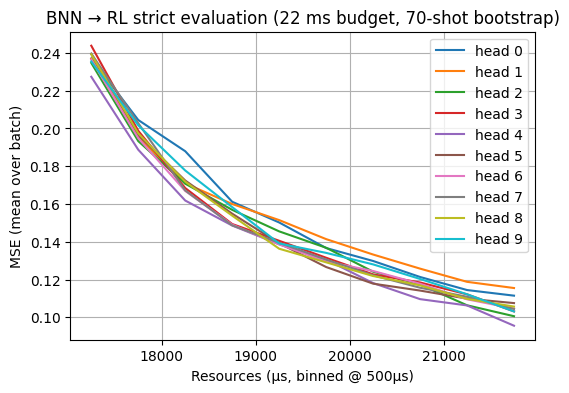

[RL-only22ms | head 0] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3773
[RL-only22ms | head 1] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3350
[RL-only22ms | head 2] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.2629
[RL-only22ms | head 3] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.2590
[RL-only22ms | head 4] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3308
[RL-only22ms | head 5] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3713
[RL-only22ms | head 6] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.2559
[RL-only22ms | head 7] steps=91 last(avg_res)=21955.4 µs last(MSE)=0.3610
[RL-only22ms | head 8] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3084
[RL-only22ms | head 9] steps=91 last(avg_res)=21955.5 µs last(MSE)=0.3353


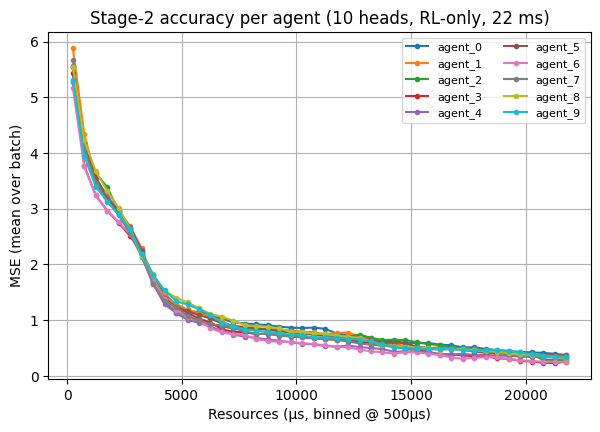

In [10]:
# ---------- One-click evaluation + 500 µs binned plots ----------
N_TEST = BATCHSIZE
true_omegas = np.sort(np.random.uniform(OMEGA_MIN, OMEGA_MAX, size=N_TEST).astype(np.float32))

# Strict (BNN→RL under 22 ms)
strict_results = eval_once_batch(true_omegas, choose_k_heads=3)

plt.figure(figsize=(6,4))
for h, res in strict_results.items():
    plt.plot(res["bin_x_us"], res["bin_mse"], label=f"head {h}")
plt.xlabel("Resources (µs, binned @ 500µs)")
plt.ylabel("MSE (mean over batch)")
plt.title("BNN → RL strict evaluation (22 ms budget, 70-shot bootstrap)")
plt.grid(True); plt.legend(); plt.show()


# RL-only (10 heads), 22 ms total
rl_only_results = eval_heads_rl_only_22ms(true_omegas, heads=list(range(len(controllers))))

plt.figure(figsize=(7,4.5))
for h, res in rl_only_results.items():
    plt.plot(res["bin_x_us"], res["bin_mse"], marker='o', ms=3, label=f"agent_{h}")
plt.xlabel("Resources (µs, binned @ 500µs)")
plt.ylabel("MSE (mean over batch)")
plt.title("Stage-2 accuracy per agent (10 heads, RL-only, 22 ms)")
plt.grid(True); plt.legend(ncol=2, fontsize=8); plt.show()